# Regression

Linear regression is a simple and powerful tool for describing relationships between a response variable and one or more explanatory variables. Here, we show how to peform ordinary least squres regression in Thunder and visualize the results.

## Setup plotting

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from thunder import Colorize
image = Colorize.image
tile = Colorize.tile
sns.set_context('notebook')
sns.set_style('darkgrid')

Load and convert data
---

Load a series of images from one of the examples.

In [3]:
data = tsc.loadExample('mouse-images')

Take a look at the first image.

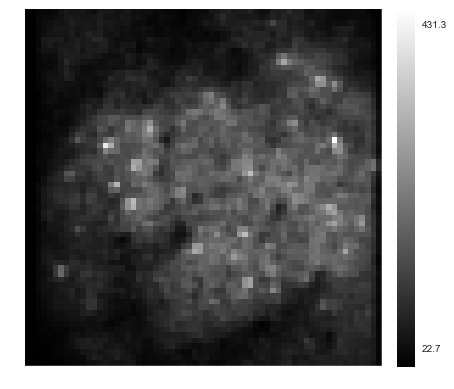

In [4]:
image(data[0], bar=True)

Convert the Images data to TimeSeries data, apply preprocessing, and cache the results. Here, the preprocessing does two things: squelches the data (to set all signals that do not exceed a threshold to 0, which helps eliminates noise), and normalizes (subtracting and removing all time series by a baseline).

In [5]:
series = data.toTimeSeries().squelch(50).normalize()
series.cache()
series.count();

Take a look at the time series of a few pixels (selected to have large standard devaitions to show activity).

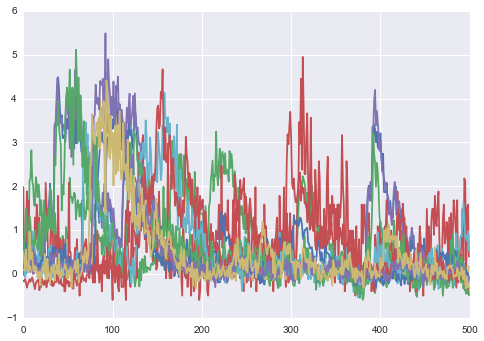

In [6]:
sample = series.subset(100, thresh=0.8)
plt.plot(sample.T);

Load in associated behavioral data to be used as explanatory variables (a.k.a regressors) in predicting the above time series.

In [7]:
regressors = tsc.loadExample('mouse-params')
regressors

Params
names: ['runningSpeed', 'corridorPosition']

We can also plot the regressors

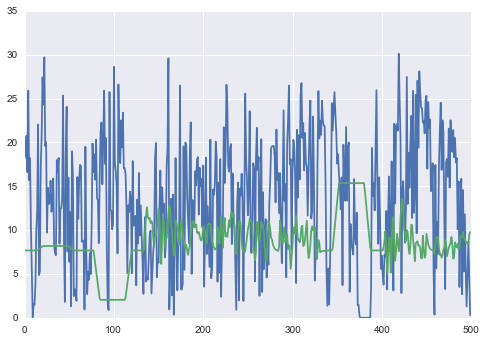

In [8]:
plt.plot(regressors['runningSpeed']);
plt.plot(regressors['corridorPosition']);

Correlation analysis
---

The correlation coefficient provides a measure of the strength of the linear relationship between two variables. When we have only a single explanatory varaible, the correlation coefficient offers a simpler alternative to a regression analysis. Let's start by correlating the activity from each pixel with one of our explanatory variables.

In [9]:
x = regressors['runningSpeed']
corrs = series.correlate(x)

We can pack these correlation coefficients back into an arrary and visualize the results. We center the values of the correlation coefficients so that positive correlations are red and negative correlations are blue.

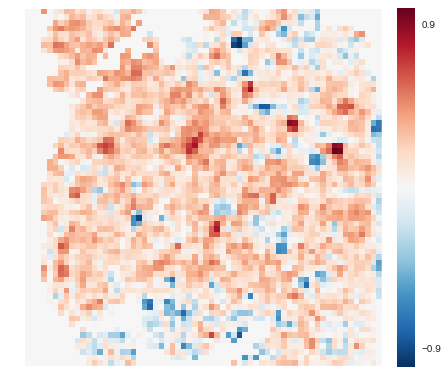

In [10]:
def center(m):
    y = m.copy()
    y[y>0] = y[y>0]/max(y[y>0])
    y[y<0] = y[y<0]/-min(y[y<0])
    return y

corrMat = center(corrs.pack())
image(corrMat, bar=True, cmap='RdBu_r')

Regression analysis
---

With more than two explanatory variables, correlation is no longer a viable optoin, so we turn to linear regression. Linear regression in Thunder models the data as:

$y=\beta X$

where $y$ is a row-vector of measurements of the response variable, $\beta$ is a row-vector of regression coeffients, one for each regressor, and $X$ is a design matrix with one row for each regressor and one column for each measurement

Since our data are time series, the columns of $y$ and $X$ represent measurements at different instants in time. Note: Thunder automatically adds a row of 1's to the design matrix to model an intercept term.

In [11]:
X = regressors[['runningSpeed', 'corridorPosition']].T

Unlike the correlation coefficient, linear regression is sensitive to the scale of the regressor. Thus, we standardize our regressors so that the resulting regression coefficients can be compared on the same scale. This will be useful later for visualization of the results.

In [12]:
from scipy.stats.mstats import zscore
X = zscore(X, axis=0)

For each pixel/series fit a linear regression model that predicts the pixel values from our regressors

In [13]:
from thunder import LinearRegression
results = LinearRegression().fit(X, series)

The result is a Series with three indices: "betas" (the regression coefficients), "stats" (the $R^2$ value), and "resid" (the residuals)

We can collect the regression coefficients and visualize how they are distribution across the image.

In [14]:
_, b1, b2 = results.coeffs.pack()
rsq = results.stats.pack()

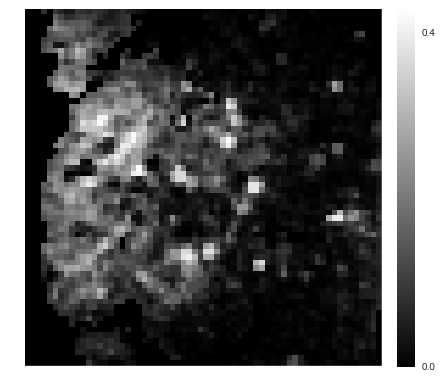

In [15]:
image(rsq, bar=True)

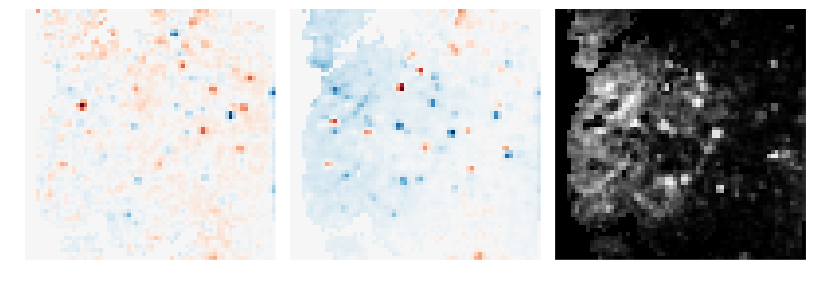

In [16]:
b1map, b2map = center(b1), center(b2)

tile([b1map, b2map, rsq], cmap=['RdBu_r', 'RdBu_r', 'gray'], grid=(1,3), size=14)

To combine these sources of information, we will make composite maps, one for the first regressor, one for the second, and one for both. In each map, we'll pick a color to represent the regressor, and use the absolute value to represent all pixels that are related to that variable, whether positively or negative. We will also use $R^2$ as a mask, and use the mean image as a background to blend in.

In [17]:
m = data.mean()

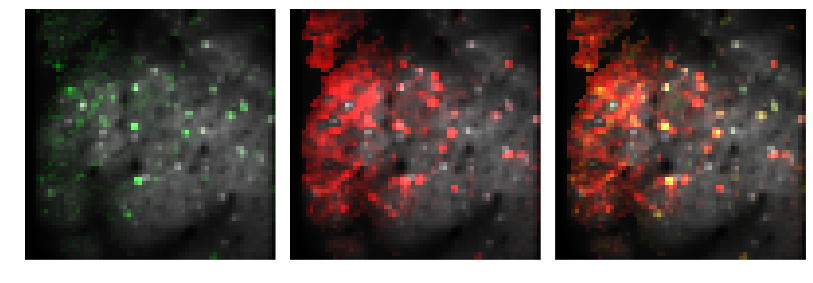

In [18]:
c = Colorize(cmap='indexed', scale=5)

c.colors = ['green']
img1 = c.transform([abs(b1)], mask=rsq, background=m, mixing=0.75)

c.colors = ['red']
img2 = c.transform([abs(b2)], mask=rsq, background=m, mixing=0.75)

c.colors = ['green', 'red']
img3 = c.transform([abs(b1), abs(b2)], mask=rsq, background=m, mixing=0.75)

tile([img1, img2, img3], grid=(1,3), size=14)